In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import libraries

import numpy as np
import pandas as pd
import time

In [3]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn import metrics

def load_csv(file, describe=False):
    df = pd.read_csv(file, na_values='NA')
    df = df.drop(['id', 'Unnamed: 0'], axis=1) # Dropping the ID column
    
    # Display basic information
    df.info()
    if describe:
        print(df.describe(include='all'))

    X = df.drop(['loss'], axis=1) # Features
    y = (df.loc[:,'loss'] > 0) # Labels
    if describe:
        print(X.shape, y.shape)
    
    return df, X, y


def split_data(kf, X, y, describe=False): 
    splits = list(kf.split(X))
    train_index, valid_index = splits[0] # Take the first split only    
    if describe:
        print("Training set: ", train_index)
        print("Validation set: ", valid_index)
    
    X_train, X_valid = X.iloc[train_index, :], X.iloc[valid_index, :]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    return X_train, y_train, X_valid, y_valid
def train_model(clf, X_train, y_train):
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    fit_time = end - start
    print('Time elapsed (Training): %.4f s' % fit_time)
    print(clf)

    return fit_time


def evaluate (clf, X_train, y_train, X_valid, y_valid, plot=True):
    # Plotting ROCAUC and PRAUC
    f, (plt1, plt2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))        
    plt1.set_title('ROC Curve')
    plt1.set_xlabel('FPR')
    plt1.set_ylabel('TPR')
    plt2.set_title('PR Curve')
    plt2.set_xlabel('Precision')
    plt2.set_ylabel('Recall')

    start = time.time()

    # Training set    
    y_train_predicted = clf.predict_proba(X_train)
    fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_predicted[:,1])
    precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_train_predicted[:,1])
    plt1.scatter(fpr, tpr, color='b')    
    plt2.scatter(precision, recall,color='b')
    print('Accuracy (Training): %f' % clf.score(X_train, y_train))
    print('ROCAUC Score (Training): %f' % metrics.roc_auc_score(y_train, y_train_predicted[:,1]))
    

# Validation set
    y_valid_predicted = clf.predict_proba(X_valid)    
    fpr, tpr, thresholds = metrics.roc_curve(y_valid, y_valid_predicted[:,1])
    precision, recall, thresholds = metrics.precision_recall_curve(y_valid, y_valid_predicted[:,1])
    plt1.scatter(fpr, tpr, color='r')
    plt2.scatter(precision, recall,color='r')
    acc_score = clf.score(X_valid, y_valid)
    print('Accuracy (Validation): %f' % acc_score)
    rocauc_score = metrics.roc_auc_score(y_valid, y_valid_predicted[:,1])
    print('ROCAUC Score (Validation): %f' % rocauc_score)
   
    

    end = time.time()
    eval_time = end - start
    print('Time elapsed (Evaluation): %.4f s' % eval_time)

    if plot:
        plt.show()
    plt.close()
    
    return acc_score, rocauc_score, eval_time

def plot_metrics (var_s, var_name, is_float, fit_times, eval_times, acc_scores, rocauc_scores):
    import matplotlib.patches as mpatches
    patches = [mpatches.Patch(color='black', label='Fitting Time'), 
               mpatches.Patch(color='blue', label='Evaluation Time')]
    plt.xlabel(var_name)
    plt.ylabel('Model Fitting/Evaluation Time (s)')
    plt.legend(handles=patches)
    plt.scatter(var_s, fit_times, color='black')
    plt.scatter(var_s, eval_times, color='blue')
    plt.show()

    patches = [mpatches.Patch(color='blue', label='Accuracy'), 
               mpatches.Patch(color='green', label='ROCAUC'), 
               ]
    plt.xlabel(var_name)
    plt.ylabel('Metrics')
    plt.legend(handles=patches)
    plt.scatter(var_s, acc_scores, color='blue')
    plt.scatter(var_s, rocauc_scores, color='green')
    
    plt.show()

    results = pd.DataFrame({'0_' + var_name: var_s, '1_Accuracy': acc_scores, '2_ROCAUC': rocauc_scores,  '4_fit_time': fit_times, '5_eval_time': eval_times})
    print(results)
    print('\n')
    print(results.describe())
    print('\n')
    if is_float:
        print('Best accuracy score=%f, at %s=%f' % (max(acc_scores), var_name, var_s[acc_scores.index(max(acc_scores))]))
        print('Best ROCAUC score=%f, at %s=%f' % (max(rocauc_scores), var_name, var_s[rocauc_scores.index(max(rocauc_scores))]))
        
    else:
        print('Best accuracy score=%f, at %s=%d' % (max(acc_scores), var_name, var_s[acc_scores.index(max(acc_scores))]))
        print('Best ROCAUC score=%f, at %s=%d' % (max(rocauc_scores), var_name, var_s[rocauc_scores.index(max(rocauc_scores))]))
       


In [4]:
# Load the training data (imputed but not normalized) from the CSV file
df, X, y = load_csv('/content/drive/MyDrive/Colab Notebooks/train_v2_preprocessed.csv')

# Separate training and validation sets
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
X_train, y_train, X_valid, y_valid = split_data(kf, X, y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105471 entries, 0 to 105470
Columns: 1789 entries, f1_x0_103 to loss
dtypes: float64(1736), int64(53)
memory usage: 1.4 GB


In [5]:
from sklearn import svm
# Downsample the DataFrame

seed = 0 # Provide the seed so the random sampling will be the same
downsample_frac = 0.05
df_downsampled = df.sample(frac=downsample_frac, random_state=seed)
df_downsampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5274 entries, 43476 to 60051
Columns: 1789 entries, f1_x0_103 to loss
dtypes: float64(1736), int64(53)
memory usage: 72.0 MB


In [6]:
# Separate data and label, training and validation sets

X = df_downsampled.drop(['loss'], axis=1) # Features
y = (df_downsampled.loc[:,'loss'] > 0) # Labels
X_train, y_train, X_valid, y_valid =split_data(kf, X, y)

Time elapsed (Training): 42.9290 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
Accuracy (Training): 0.913487
ROCAUC Score (Training): 0.495838
Accuracy (Validation): 0.891943
ROCAUC Score (Validation): 0.480018
Time elapsed (Evaluation): 16.9136 s


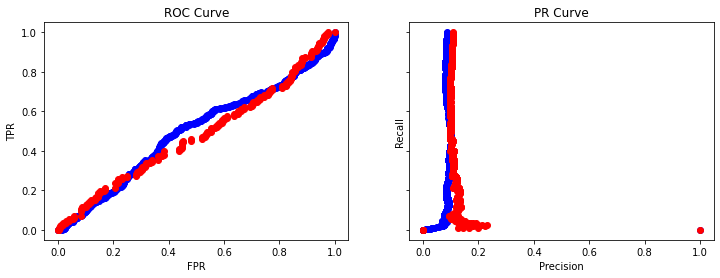

In [7]:
# Train and evaluate the model again

clf = svm.SVC(probability=True) # Set probability=True to enable the predict_proba() API
fit_time = train_model(clf, X_train, y_train)
acc_score, rocauc_score,  eval_time = evaluate(clf, X_train, y_train, X_valid, y_valid)

Time elapsed (Training): 173.8971 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.811567
ROCAUC Score (Training): 0.603277
Accuracy (Validation): 0.773460
ROCAUC Score (Validation): 0.560735
Time elapsed (Evaluation): 75.1783 s


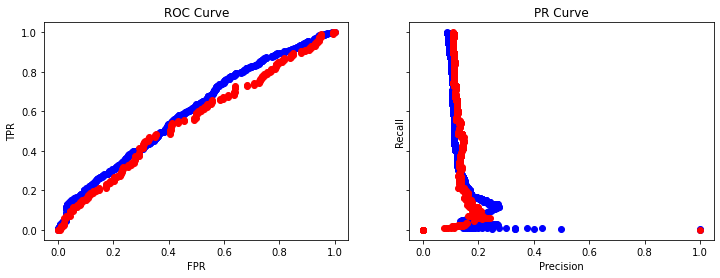

In [9]:
class_weight = {0: 1., 1: 10.}
clf = svm.SVC(probability=True, class_weight=class_weight) # Set probability=True to enable the predict_proba() API
fit_time = train_model(clf, X_train, y_train)
acc_score, rocauc_score,  eval_time = evaluate(clf, X_train, y_train, X_valid, y_valid)

In [ ]:
# Load the training data (imputed and normalized) from the CSV file
df, X, y = load_csv('/content/drive/MyDrive/Colab Notebooks/train_v2_preprocessed_normalized.csv')

# Separate training and validation sets
X_train, y_train, X_valid, y_valid =split_data(kf, X, y)

# Downsample with the same random seed
df_downsampled = df.sample(frac=downsample_frac, random_state=seed)
df_downsampled.info()

# Separate data and label, training and validation sets
X = df_downsampled.drop(['loss'], axis=1) # Features
y = (df_downsampled.loc[:,'loss'] > 0) # Labels
X_train, y_train, X_valid, y_valid = split_data(kf, X, y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105471 entries, 0 to 105470
Columns: 1789 entries, f3 to loss
dtypes: float64(1788), int64(1)
memory usage: 1.4 GB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5274 entries, 43476 to 60051
Columns: 1789 entries, f3 to loss
dtypes: float64(1788), int64(1)
memory usage: 72.0 MB


Time elapsed (Training): 99.8581 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
Accuracy (Training): 0.915146
ROCAUC Score (Training): 0.998632
Accuracy (Validation): 0.892891
ROCAUC Score (Validation): 0.595927
Time elapsed (Evaluation): 43.7789 s


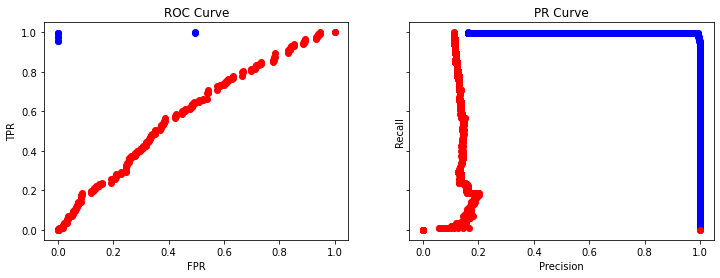

In [ ]:
# Train and evaluate the model

clf = svm.SVC(probability=True)
fit_time = train_model(clf, X_train, y_train)
acc_score, rocauc_score,  eval_time = evaluate(clf, X_train, y_train, X_valid, y_valid)

Time elapsed (Training): 128.4424 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.945959
ROCAUC Score (Training): 0.998215
Accuracy (Validation): 0.805687
ROCAUC Score (Validation): 0.614565
Time elapsed (Evaluation): 56.9865 s


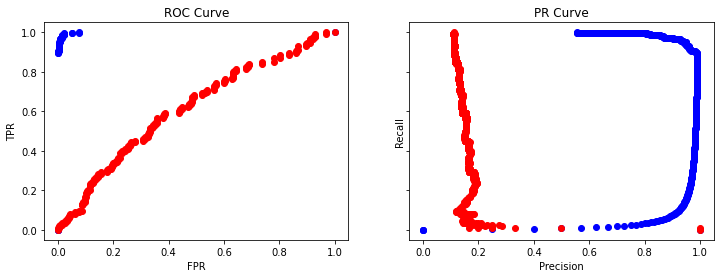

In [ ]:
# Adding class weights and then train and evaluate the model

class_weight = {0: 1., 1: 10.}
clf = svm.SVC(probability=True, class_weight=class_weight) # Set probability=True to enable the predict_proba() API
fit_time =train_model(clf, X_train, y_train)
acc_score, rocauc_score, eval_time = evaluate(clf, X_train, y_train, X_valid, y_valid)


----- gamma = 0.000010 -----
Time elapsed (Training): 172.5261 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=1e-05,
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.645888
ROCAUC Score (Training): 0.675490
Accuracy (Validation): 0.629384
ROCAUC Score (Validation): 0.631898
Time elapsed (Evaluation): 79.8172 s


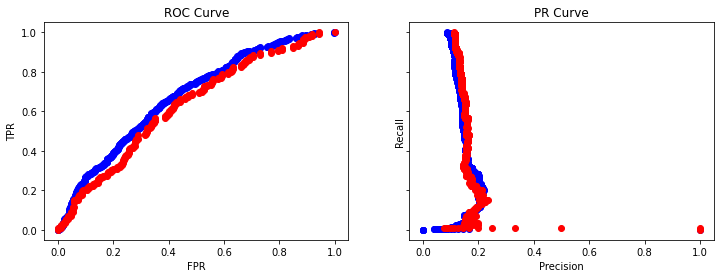

----- gamma = 0.000020 -----
Time elapsed (Training): 171.1381 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=2e-05,
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.652998
ROCAUC Score (Training): 0.693975
Accuracy (Validation): 0.625592
ROCAUC Score (Validation): 0.635599
Time elapsed (Evaluation): 94.4767 s


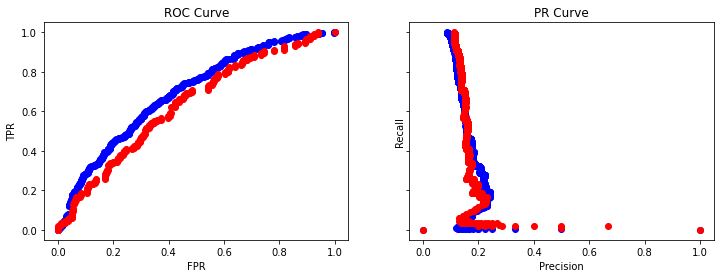

----- gamma = 0.000050 -----
Time elapsed (Training): 166.5511 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=5e-05,
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.655606
ROCAUC Score (Training): 0.731320
Accuracy (Validation): 0.625592
ROCAUC Score (Validation): 0.642777
Time elapsed (Evaluation): 74.0273 s


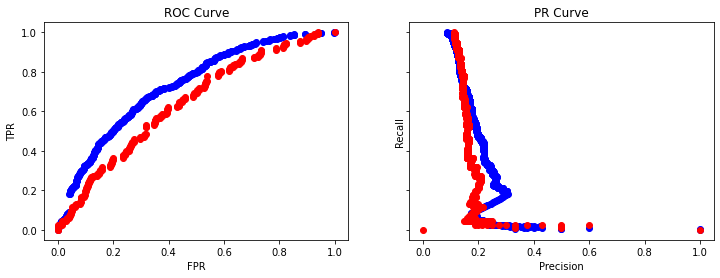

----- gamma = 0.000100 -----
Time elapsed (Training): 160.0345 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.0001,
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.673145
ROCAUC Score (Training): 0.771010
Accuracy (Validation): 0.618009
ROCAUC Score (Validation): 0.645172
Time elapsed (Evaluation): 90.3630 s


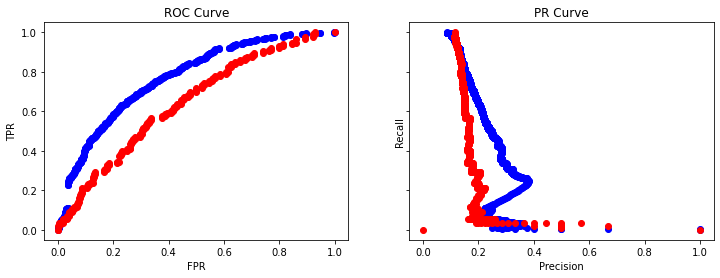

----- gamma = 0.000200 -----
Time elapsed (Training): 154.8284 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.0002,
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.713913
ROCAUC Score (Training): 0.828206
Accuracy (Validation): 0.648341
ROCAUC Score (Validation): 0.642598
Time elapsed (Evaluation): 86.5791 s


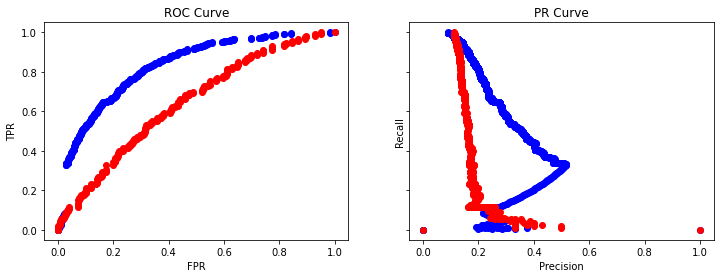

----- gamma = 0.000500 -----
Time elapsed (Training): 143.0045 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.0005,
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.804930
ROCAUC Score (Training): 0.929741
Accuracy (Validation): 0.693839
ROCAUC Score (Validation): 0.632574
Time elapsed (Evaluation): 78.7892 s


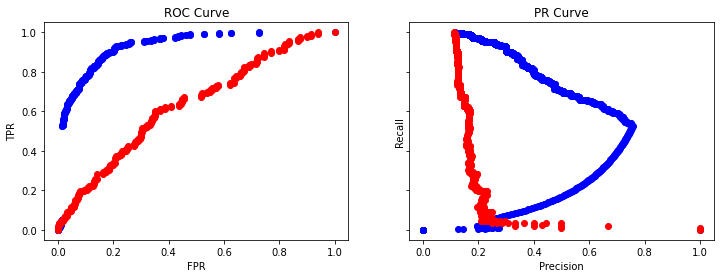

----- gamma = 0.001000 -----
Time elapsed (Training): 129.3861 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.001,
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.901398
ROCAUC Score (Training): 0.988602
Accuracy (Validation): 0.771564
ROCAUC Score (Validation): 0.621329
Time elapsed (Evaluation): 72.1214 s


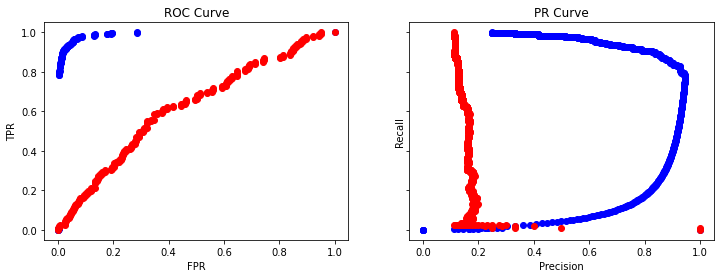

----- gamma = 0.005000 -----
Time elapsed (Training): 177.6893 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.005,
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 1.000000
ROCAUC Score (Training): 1.000000
Accuracy (Validation): 0.891943
ROCAUC Score (Validation): 0.588928
Time elapsed (Evaluation): 92.2935 s


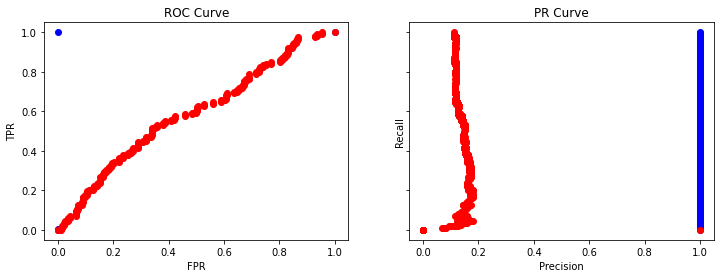

----- gamma = 0.010000 -----
Time elapsed (Training): 192.1092 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.01,
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 1.000000
ROCAUC Score (Training): 1.000000
Accuracy (Validation): 0.892891
ROCAUC Score (Validation): 0.601789
Time elapsed (Evaluation): 107.6262 s


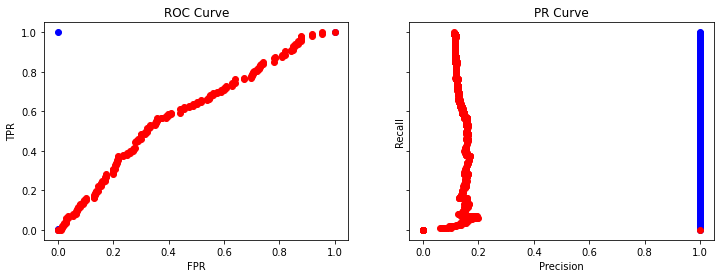

----- gamma = 0.050000 -----
Time elapsed (Training): 196.7480 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.05,
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 1.000000
ROCAUC Score (Training): 0.000000
Accuracy (Validation): 0.892891
ROCAUC Score (Validation): 0.430444
Time elapsed (Evaluation): 111.4471 s


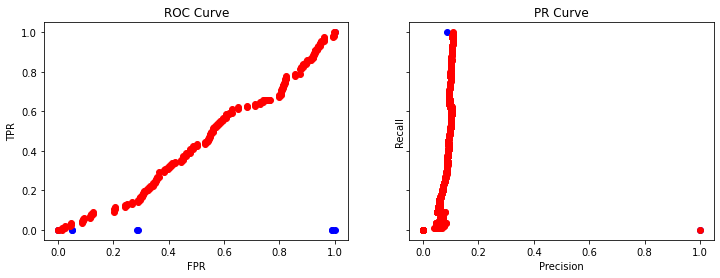

----- gamma = 0.100000 -----
Time elapsed (Training): 193.5009 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
Accuracy (Training): 1.000000
ROCAUC Score (Training): 0.000000
Accuracy (Validation): 0.892891
ROCAUC Score (Validation): 0.437644
Time elapsed (Evaluation): 110.9118 s


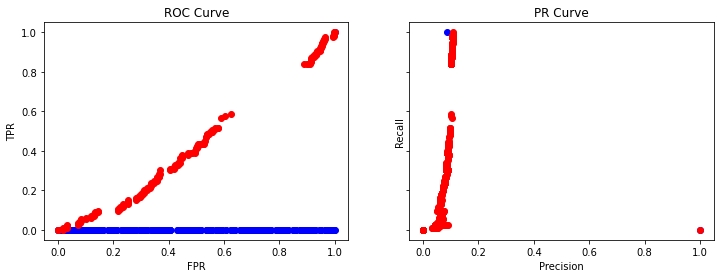

In [ ]:

# Define a set of values to try

ks = [1e-5, 2e-5, 5e-5, 1e-4, 2e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 0.1]
fit_times = []; eval_times = []; acc_scores = []; rocauc_scores = []; 

for k in ks:
    print('----- gamma = %f -----' % k)
    clf = svm.SVC(probability=True, class_weight=class_weight, gamma=k)
    fit_time = train_model(clf, X_train, y_train)
    acc_score, rocauc_score, eval_time = evaluate(clf, X_train, y_train, X_valid, y_valid)
    fit_times.append(fit_time); eval_times.append(eval_time)
    acc_scores.append(acc_score); rocauc_scores.append(rocauc_score)

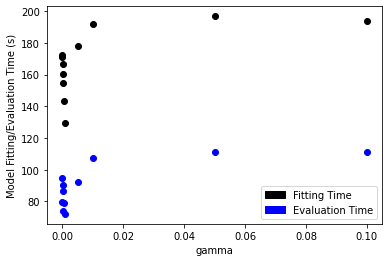

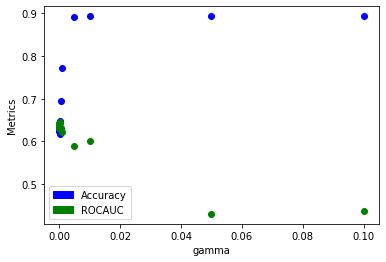

    0_gamma  1_Accuracy  2_ROCAUC  4_fit_time  5_eval_time
0   0.00001    0.629384  0.631898  172.526098    79.817230
1   0.00002    0.625592  0.635599  171.138134    94.476747
2   0.00005    0.625592  0.642777  166.551116    74.027319
3   0.00010    0.618009  0.645172  160.034503    90.362969
4   0.00020    0.648341  0.642598  154.828382    86.579062
5   0.00050    0.693839  0.632574  143.004501    78.789193
6   0.00100    0.771564  0.621329  129.386087    72.121421
7   0.00500    0.891943  0.588928  177.689261    92.293546
8   0.01000    0.892891  0.601789  192.109225   107.626159
9   0.05000    0.892891  0.430444  196.747956   111.447067
10  0.10000    0.892891  0.437644  193.500918   110.911819


         0_gamma  1_Accuracy   2_ROCAUC  4_fit_time  5_eval_time
count  11.000000   11.000000  11.000000   11.000000    11.000000
mean    0.015171    0.743903   0.591887  168.865107    90.768412
std     0.031772    0.125646   0.079998   21.281044    14.292462
min     0.000010    0.618009  

In [ ]:
plot_metrics(ks, 'gamma', True, fit_times, eval_times, acc_scores, rocauc_scores)

Time elapsed (Training): 142.3838 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
Accuracy (Training): 0.945485
ROCAUC Score (Training): 0.886067
Accuracy (Validation): 0.854976
ROCAUC Score (Validation): 0.586560
Time elapsed (Evaluation): 27.5693 s


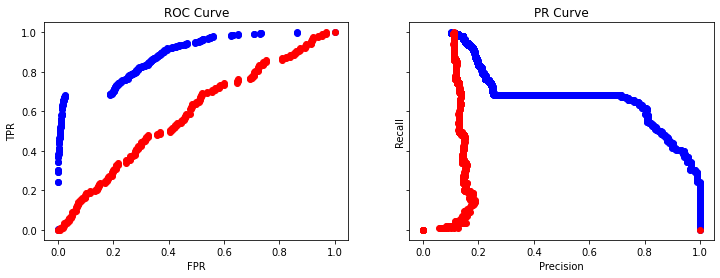

In [ ]:
# Train and evaluate the model with linear kernel

clf = svm.SVC(probability=True, kernel='linear') # Set probability=True to enable the predict_proba() API
fit_time = train_model(clf, X_train, y_train)
acc_score, rocauc_score,  eval_time = evaluate(clf, X_train, y_train, X_valid, y_valid)

Time elapsed (Training): 133.5700 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=2, gamma='scale',
    kernel='poly', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.920834
ROCAUC Score (Training): 0.985938
Accuracy (Validation): 0.786730
ROCAUC Score (Validation): 0.582990
Time elapsed (Evaluation): 73.3625 s


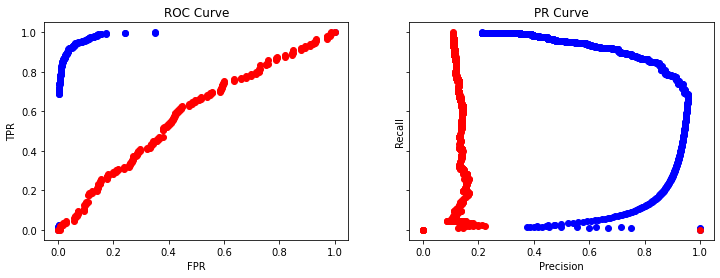

In [ ]:
# Train and evaluate the model with degree 2

clf = svm.SVC(probability=True, class_weight=class_weight, kernel='poly', degree=2) # Set probability=True to enable the predict_proba() API
fit_time = train_model(clf, X_train, y_train)
acc_score, rocauc_score,  eval_time = evaluate(clf, X_train, y_train, X_valid, y_valid)

----- gamma = 0.000010 -----
Time elapsed (Training): 182.9402 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=2, gamma=1e-05,
    kernel='poly', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.913250
ROCAUC Score (Training): 0.656333
Accuracy (Validation): 0.891943
ROCAUC Score (Validation): 0.579796
Time elapsed (Evaluation): 101.6855 s


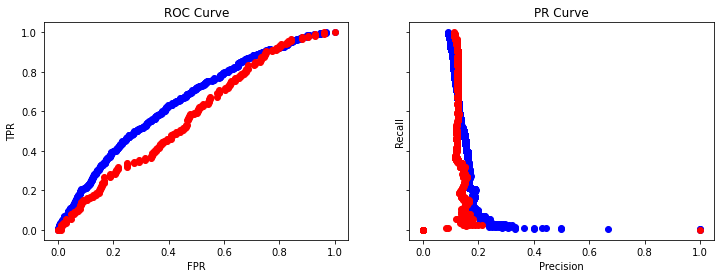

----- gamma = 0.000020 -----
Time elapsed (Training): 181.9569 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=2, gamma=2e-05,
    kernel='poly', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.913250
ROCAUC Score (Training): 0.663099
Accuracy (Validation): 0.891943
ROCAUC Score (Validation): 0.584099
Time elapsed (Evaluation): 95.2151 s


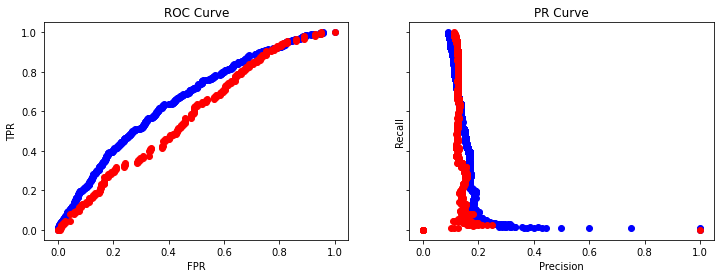

----- gamma = 0.000050 -----
Time elapsed (Training): 182.8053 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=2, gamma=5e-05,
    kernel='poly', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.910879
ROCAUC Score (Training): 0.664778
Accuracy (Validation): 0.886256
ROCAUC Score (Validation): 0.585724
Time elapsed (Evaluation): 85.5450 s


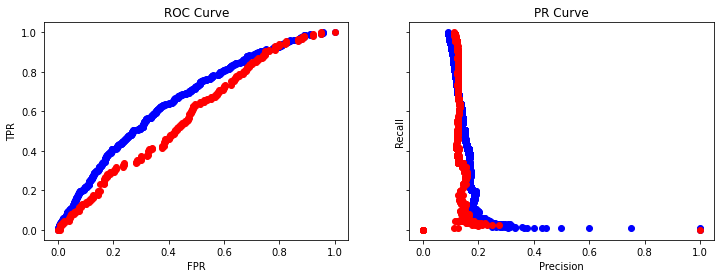

----- gamma = 0.000100 -----
Time elapsed (Training): 179.9117 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=2, gamma=0.0001,
    kernel='poly', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.901872
ROCAUC Score (Training): 0.687105
Accuracy (Validation): 0.877725
ROCAUC Score (Validation): 0.597148
Time elapsed (Evaluation): 84.8411 s


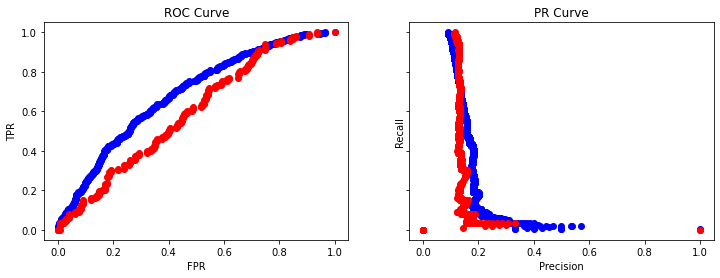

----- gamma = 0.000200 -----
Time elapsed (Training): 177.2759 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=2, gamma=0.0002,
    kernel='poly', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.872245
ROCAUC Score (Training): 0.727419
Accuracy (Validation): 0.838863
ROCAUC Score (Validation): 0.604560
Time elapsed (Evaluation): 83.4839 s


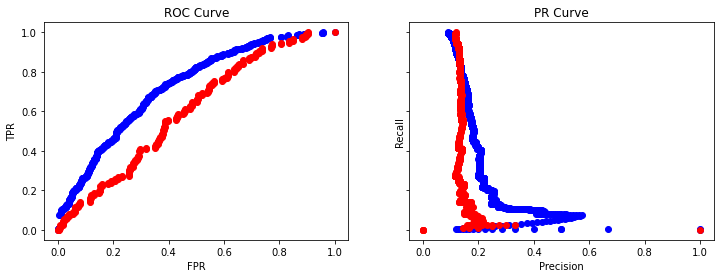

----- gamma = 0.000500 -----
Time elapsed (Training): 165.5250 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=2, gamma=0.0005,
    kernel='poly', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.852098
ROCAUC Score (Training): 0.851847
Accuracy (Validation): 0.760190
ROCAUC Score (Validation): 0.605744
Time elapsed (Evaluation): 78.4839 s


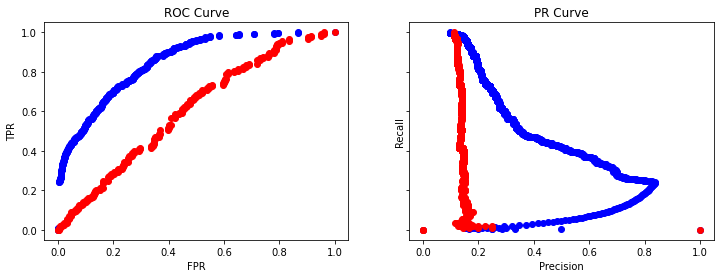

----- gamma = 0.001000 -----
Time elapsed (Training): 144.7614 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=2, gamma=0.001,
    kernel='poly', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.889547
ROCAUC Score (Training): 0.961742
Accuracy (Validation): 0.766825
ROCAUC Score (Validation): 0.591878
Time elapsed (Evaluation): 80.6372 s


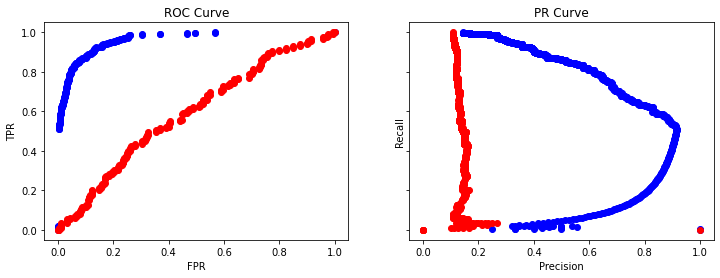

----- gamma = 0.005000 -----
Time elapsed (Training): 87.7628 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=2, gamma=0.005,
    kernel='poly', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.999763
ROCAUC Score (Training): 1.000000
Accuracy (Validation): 0.847393
ROCAUC Score (Validation): 0.553126
Time elapsed (Evaluation): 45.5861 s


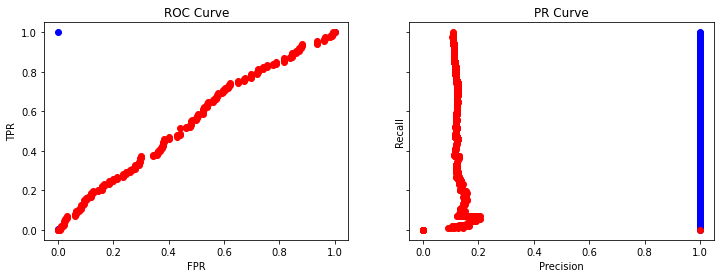

----- gamma = 0.010000 -----
Time elapsed (Training): 87.9513 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=2, gamma=0.01,
    kernel='poly', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 1.000000
ROCAUC Score (Training): 1.000000
Accuracy (Validation): 0.849289
ROCAUC Score (Validation): 0.556545
Time elapsed (Evaluation): 44.8290 s


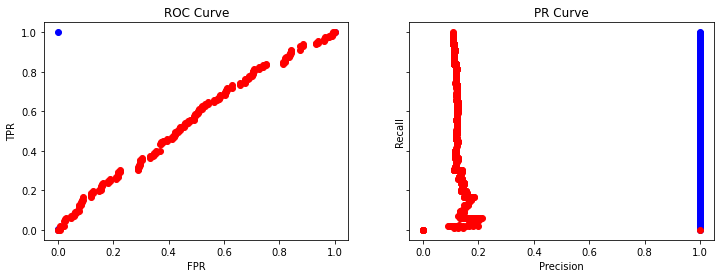

----- gamma = 0.050000 -----
Time elapsed (Training): 87.1799 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=2, gamma=0.05,
    kernel='poly', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 1.000000
ROCAUC Score (Training): 1.000000
Accuracy (Validation): 0.849289
ROCAUC Score (Validation): 0.556498
Time elapsed (Evaluation): 44.6905 s


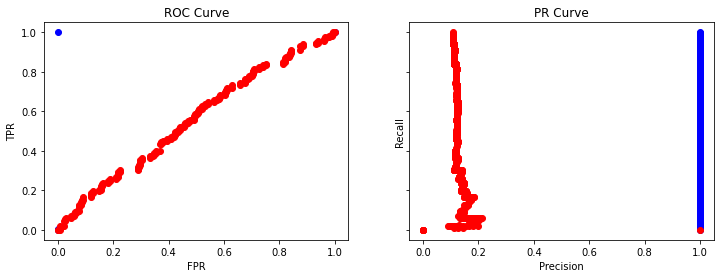

----- gamma = 0.100000 -----
Time elapsed (Training): 86.7357 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=2, gamma=0.1,
    kernel='poly', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 1.000000
ROCAUC Score (Training): 1.000000
Accuracy (Validation): 0.849289
ROCAUC Score (Validation): 0.556526
Time elapsed (Evaluation): 45.0647 s


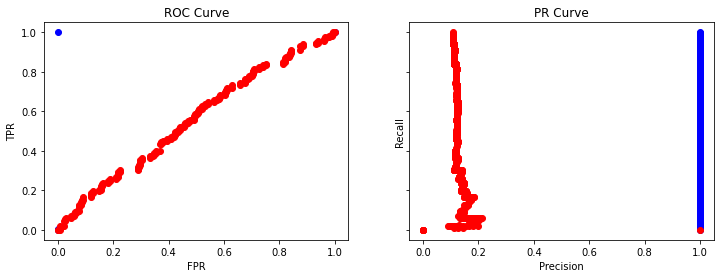

In [ ]:

# Define a set of values to try

ks = [1e-5, 2e-5, 5e-5, 1e-4, 2e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 0.1]
fit_times = []; eval_times = []; acc_scores = []; rocauc_scores = []; prauc_scores = []

for k in ks:
    print('----- gamma = %f -----' % k)
    clf = svm.SVC(probability=True, class_weight=class_weight, kernel='poly', degree=2, gamma=k)
    fit_time = train_model(clf, X_train, y_train)
    acc_score, rocauc_score, eval_time = evaluate(clf, X_train, y_train, X_valid, y_valid)
    fit_times.append(fit_time); eval_times.append(eval_time)
    acc_scores.append(acc_score); rocauc_scores.append(rocauc_score)

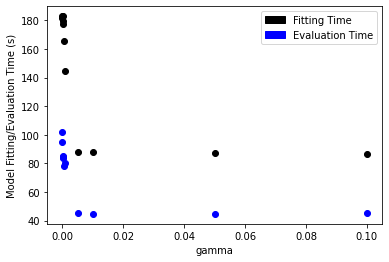

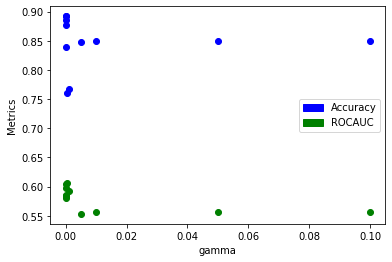

    0_gamma  1_Accuracy  2_ROCAUC  4_fit_time  5_eval_time
0   0.00001    0.891943  0.579796  182.940210   101.685453
1   0.00002    0.891943  0.584099  181.956911    95.215079
2   0.00005    0.886256  0.585724  182.805305    85.545021
3   0.00010    0.877725  0.597148  179.911670    84.841130
4   0.00020    0.838863  0.604560  177.275924    83.483928
5   0.00050    0.760190  0.605744  165.524954    78.483943
6   0.00100    0.766825  0.591878  144.761408    80.637200
7   0.00500    0.847393  0.553126   87.762782    45.586056
8   0.01000    0.849289  0.556545   87.951293    44.828995
9   0.05000    0.849289  0.556498   87.179940    44.690453
10  0.10000    0.849289  0.556526   86.735734    45.064729


         0_gamma  1_Accuracy   2_ROCAUC  4_fit_time  5_eval_time
count  11.000000   11.000000  11.000000   11.000000    11.000000
mean    0.015171    0.846273   0.579240  142.255103    71.823817
std     0.031772    0.045349   0.020298   44.835325    22.190066
min     0.000010    0.760190  

In [ ]:
plot_metrics(ks, 'gamma', True, fit_times, eval_times, acc_scores, rocauc_scores)

----- gamma = 0.000010 -----
Time elapsed (Training): 178.9050 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=1e-05,
    kernel='poly', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.913250
ROCAUC Score (Training): 0.680233
Accuracy (Validation): 0.891943
ROCAUC Score (Validation): 0.604832
Time elapsed (Evaluation): 85.6825 s


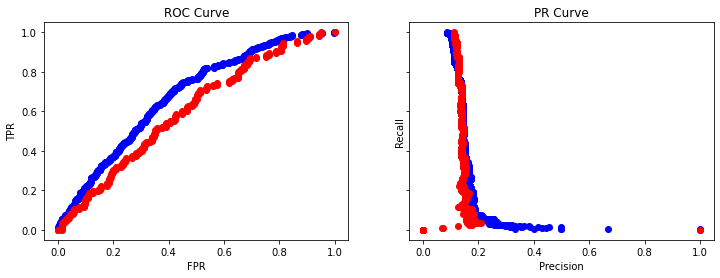

----- gamma = 0.000020 -----
Time elapsed (Training): 180.2602 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=2e-05,
    kernel='poly', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.913250
ROCAUC Score (Training): 0.687304
Accuracy (Validation): 0.891943
ROCAUC Score (Validation): 0.605133
Time elapsed (Evaluation): 85.5221 s


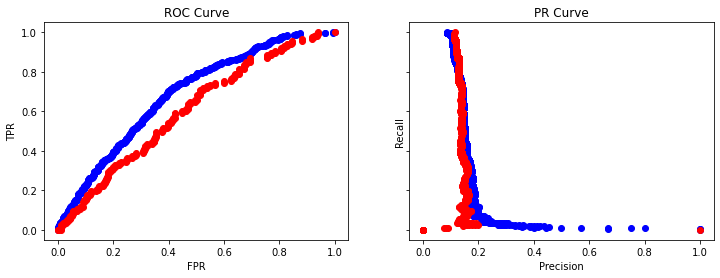

----- gamma = 0.000050 -----
Time elapsed (Training): 180.0793 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=5e-05,
    kernel='poly', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.913250
ROCAUC Score (Training): 0.310351
Accuracy (Validation): 0.891943
ROCAUC Score (Validation): 0.394040
Time elapsed (Evaluation): 85.6149 s


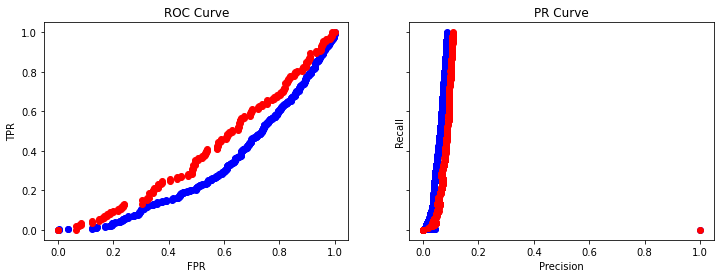

----- gamma = 0.000100 -----
Time elapsed (Training): 180.9413 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.0001,
    kernel='poly', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.911116
ROCAUC Score (Training): 0.695076
Accuracy (Validation): 0.886256
ROCAUC Score (Validation): 0.609661
Time elapsed (Evaluation): 86.5699 s


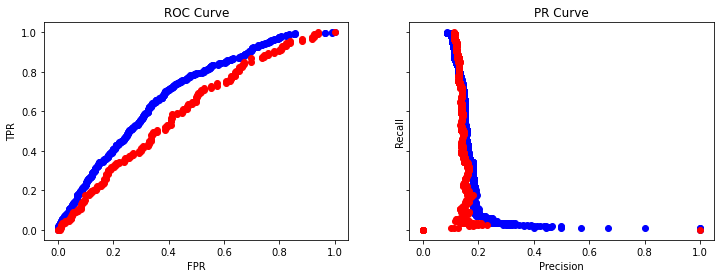

----- gamma = 0.000200 -----
Time elapsed (Training): 178.5465 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.0002,
    kernel='poly', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.901635
ROCAUC Score (Training): 0.717978
Accuracy (Validation): 0.876777
ROCAUC Score (Validation): 0.615270
Time elapsed (Evaluation): 84.8606 s


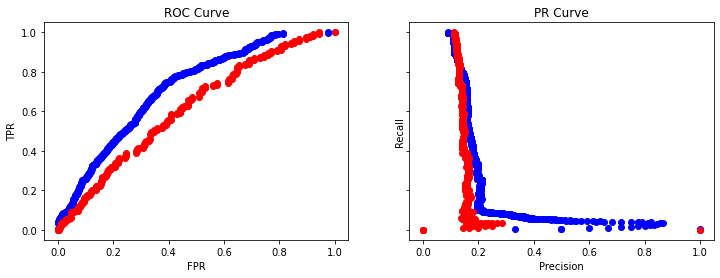

----- gamma = 0.000500 -----
Time elapsed (Training): 169.0184 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.0005,
    kernel='poly', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.905902
ROCAUC Score (Training): 0.833758
Accuracy (Validation): 0.843602
ROCAUC Score (Validation): 0.622720
Time elapsed (Evaluation): 80.8715 s


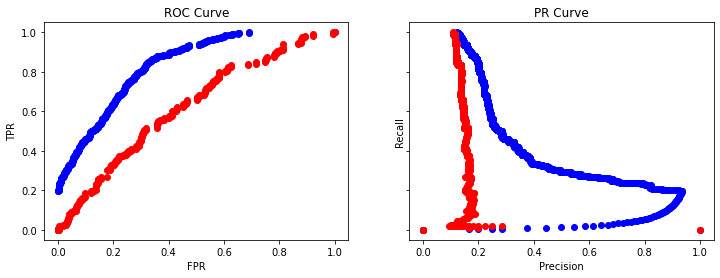

----- gamma = 0.001000 -----
Time elapsed (Training): 148.8775 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.001,
    kernel='poly', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.949040
ROCAUC Score (Training): 0.967461
Accuracy (Validation): 0.837915
ROCAUC Score (Validation): 0.611756
Time elapsed (Evaluation): 83.4252 s


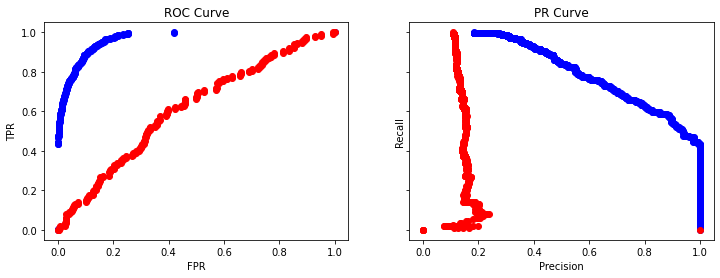

----- gamma = 0.005000 -----
Time elapsed (Training): 148.9356 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.005,
    kernel='poly', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 1.000000
ROCAUC Score (Training): 1.000000
Accuracy (Validation): 0.865403
ROCAUC Score (Validation): 0.587904
Time elapsed (Evaluation): 58.7350 s


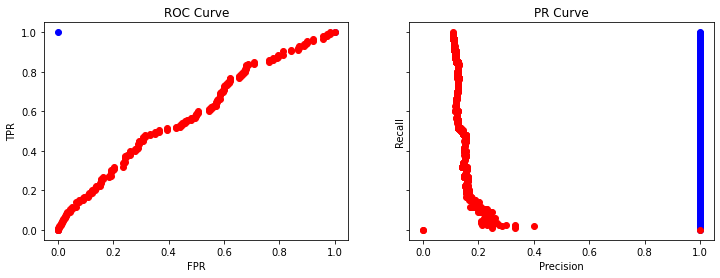

----- gamma = 0.010000 -----
Time elapsed (Training): 142.1422 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.01,
    kernel='poly', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 1.000000
ROCAUC Score (Training): 1.000000
Accuracy (Validation): 0.865403
ROCAUC Score (Validation): 0.587904
Time elapsed (Evaluation): 57.6794 s


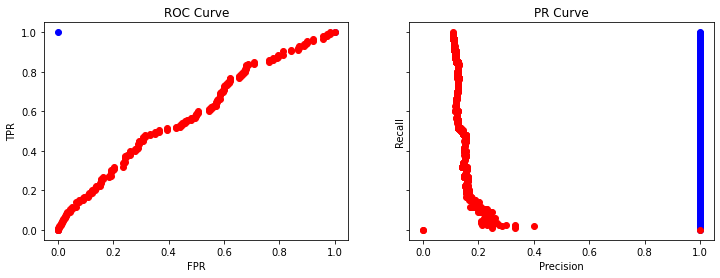

----- gamma = 0.050000 -----
Time elapsed (Training): 140.9270 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.05,
    kernel='poly', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 1.000000
ROCAUC Score (Training): 1.000000
Accuracy (Validation): 0.865403
ROCAUC Score (Validation): 0.587913
Time elapsed (Evaluation): 58.2364 s


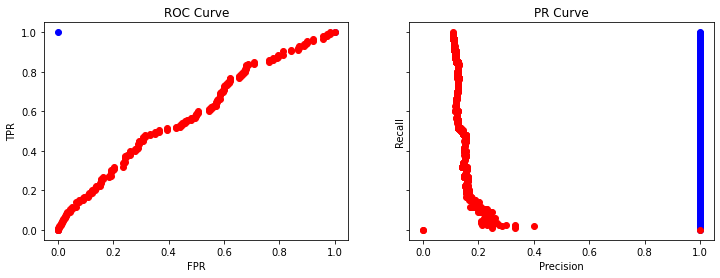

----- gamma = 0.100000 -----
Time elapsed (Training): 140.1090 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.1,
    kernel='poly', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 1.000000
ROCAUC Score (Training): 1.000000
Accuracy (Validation): 0.865403
ROCAUC Score (Validation): 0.587913
Time elapsed (Evaluation): 57.6036 s


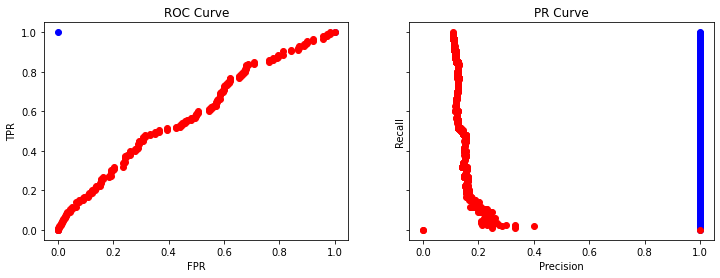

In [ ]:
fit_times = []; eval_times = []; acc_scores = []; rocauc_scores = [];

for k in ks:
    print('----- gamma = %f -----' % k)
    clf = svm.SVC(probability=True, class_weight=class_weight, kernel='poly', degree=3, gamma=k)
    fit_time = train_model(clf, X_train, y_train)
    acc_score, rocauc_score,eval_time = evaluate(clf, X_train, y_train, X_valid, y_valid)
    fit_times.append(fit_time); eval_times.append(eval_time)
    acc_scores.append(acc_score); rocauc_scores.append(rocauc_score)

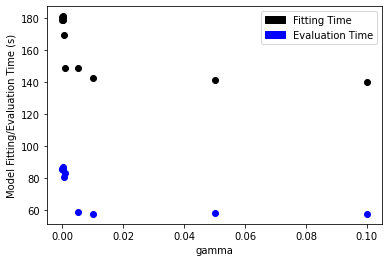

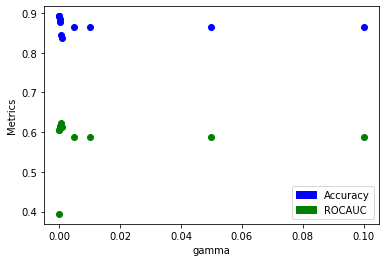

    0_gamma  1_Accuracy  2_ROCAUC  4_fit_time  5_eval_time
0   0.00001    0.891943  0.604832  178.905028    85.682549
1   0.00002    0.891943  0.605133  180.260178    85.522062
2   0.00005    0.891943  0.394040  180.079268    85.614903
3   0.00010    0.886256  0.609661  180.941297    86.569877
4   0.00020    0.876777  0.615270  178.546505    84.860564
5   0.00050    0.843602  0.622720  169.018421    80.871528
6   0.00100    0.837915  0.611756  148.877486    83.425191
7   0.00500    0.865403  0.587904  148.935579    58.735009
8   0.01000    0.865403  0.587904  142.142249    57.679400
9   0.05000    0.865403  0.587913  140.927012    58.236359
10  0.10000    0.865403  0.587913  140.108974    57.603612


         0_gamma  1_Accuracy   2_ROCAUC  4_fit_time  5_eval_time
count  11.000000   11.000000  11.000000   11.000000    11.000000
mean    0.015171    0.871090   0.583186  162.612909    74.981914
std     0.031772    0.018848   0.063973   18.122520    13.499118
min     0.000010    0.837915  

In [ ]:
plot_metrics(ks, 'gamma', True, fit_times, eval_times, acc_scores, rocauc_scores)

----- gamma = 0.000010 -----
Time elapsed (Training): 180.7885 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=4, gamma=1e-05,
    kernel='poly', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.913250
ROCAUC Score (Training): 0.652591
Accuracy (Validation): 0.891943
ROCAUC Score (Validation): 0.529555
Time elapsed (Evaluation): 87.4872 s


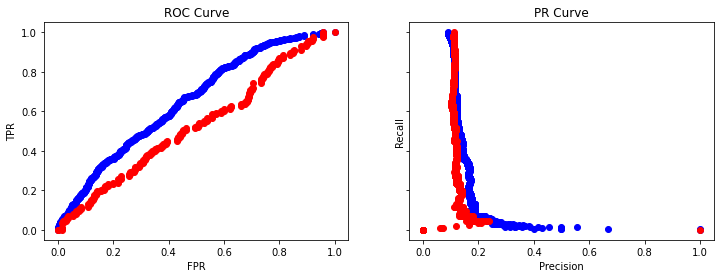

----- gamma = 0.000020 -----
Time elapsed (Training): 182.0461 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=4, gamma=2e-05,
    kernel='poly', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.913250
ROCAUC Score (Training): 0.682450
Accuracy (Validation): 0.891943
ROCAUC Score (Validation): 0.546897
Time elapsed (Evaluation): 86.9436 s


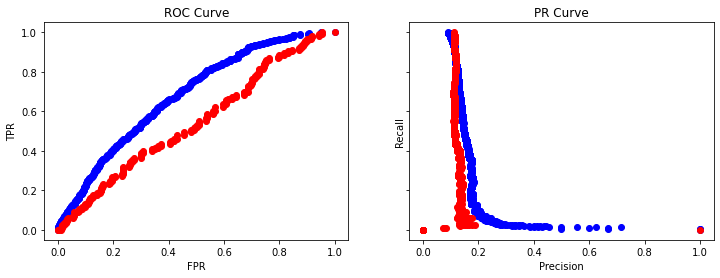

----- gamma = 0.000050 -----
Time elapsed (Training): 186.3317 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=4, gamma=5e-05,
    kernel='poly', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.913250
ROCAUC Score (Training): 0.691249
Accuracy (Validation): 0.891943
ROCAUC Score (Validation): 0.550551
Time elapsed (Evaluation): 90.2500 s


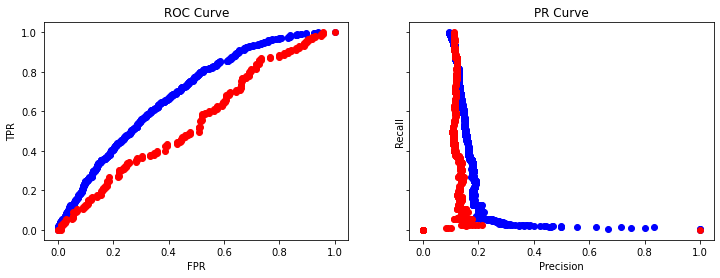

----- gamma = 0.000100 -----
Time elapsed (Training): 185.9652 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=4, gamma=0.0001,
    kernel='poly', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.913250
ROCAUC Score (Training): 0.701911
Accuracy (Validation): 0.891943
ROCAUC Score (Validation): 0.562708
Time elapsed (Evaluation): 87.6895 s


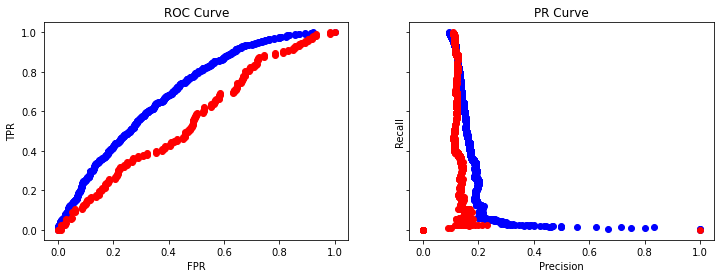

----- gamma = 0.000200 -----
Time elapsed (Training): 182.5513 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=4, gamma=0.0002,
    kernel='poly', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.913250
ROCAUC Score (Training): 0.741652
Accuracy (Validation): 0.888152
ROCAUC Score (Validation): 0.577692
Time elapsed (Evaluation): 87.6325 s


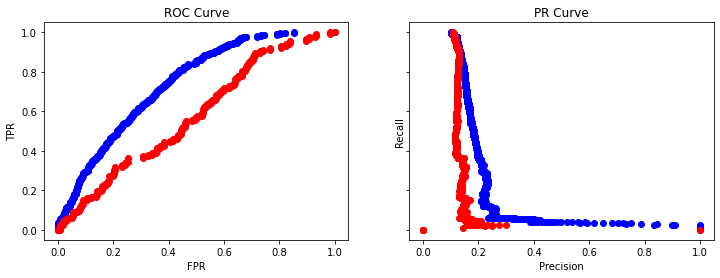

----- gamma = 0.000500 -----
Time elapsed (Training): 177.9562 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=4, gamma=0.0005,
    kernel='poly', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.926049
ROCAUC Score (Training): 0.156825
Accuracy (Validation): 0.875829
ROCAUC Score (Validation): 0.422477
Time elapsed (Evaluation): 83.7952 s


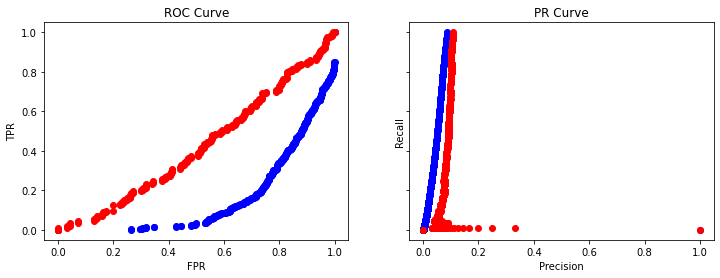

----- gamma = 0.001000 -----
Time elapsed (Training): 161.2893 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=4, gamma=0.001,
    kernel='poly', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.952358
ROCAUC Score (Training): 0.035594
Accuracy (Validation): 0.867299
ROCAUC Score (Validation): 0.402815
Time elapsed (Evaluation): 76.1623 s


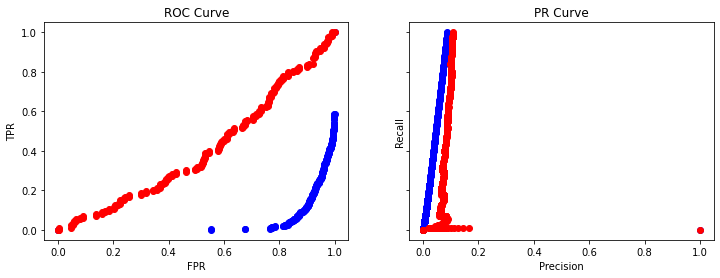

----- gamma = 0.005000 -----
Time elapsed (Training): 161.9815 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=4, gamma=0.005,
    kernel='poly', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 1.000000
ROCAUC Score (Training): 1.000000
Accuracy (Validation): 0.862559
ROCAUC Score (Validation): 0.555484
Time elapsed (Evaluation): 67.7404 s


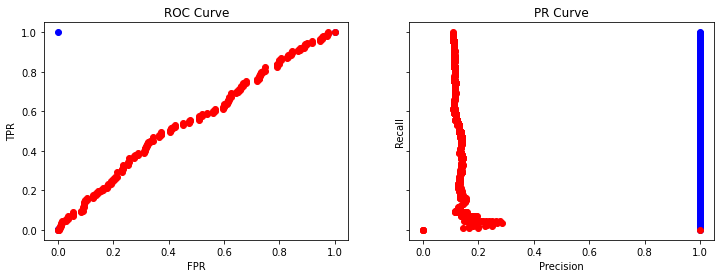

----- gamma = 0.010000 -----
Time elapsed (Training): 153.8054 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=4, gamma=0.01,
    kernel='poly', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 1.000000
ROCAUC Score (Training): 0.000000
Accuracy (Validation): 0.862559
ROCAUC Score (Validation): 0.444488
Time elapsed (Evaluation): 66.2611 s


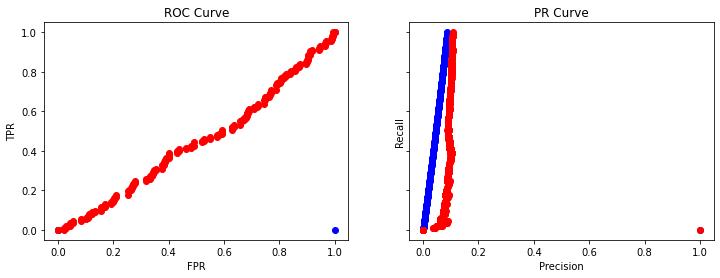

----- gamma = 0.050000 -----
Time elapsed (Training): 167.4836 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=4, gamma=0.05,
    kernel='poly', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 1.000000
ROCAUC Score (Training): 0.000000
Accuracy (Validation): 0.862559
ROCAUC Score (Validation): 0.444507
Time elapsed (Evaluation): 66.6689 s


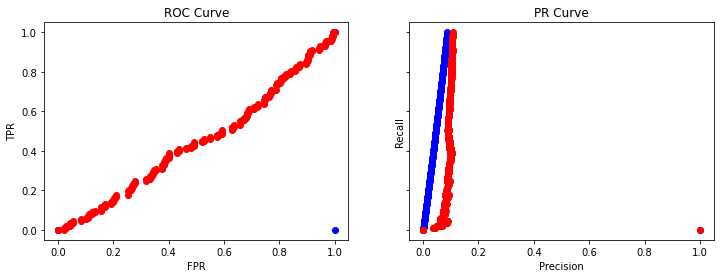

----- gamma = 0.100000 -----
Time elapsed (Training): 155.7892 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=4, gamma=0.1,
    kernel='poly', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 1.000000
ROCAUC Score (Training): 0.000000
Accuracy (Validation): 0.862559
ROCAUC Score (Validation): 0.444507
Time elapsed (Evaluation): 67.4029 s


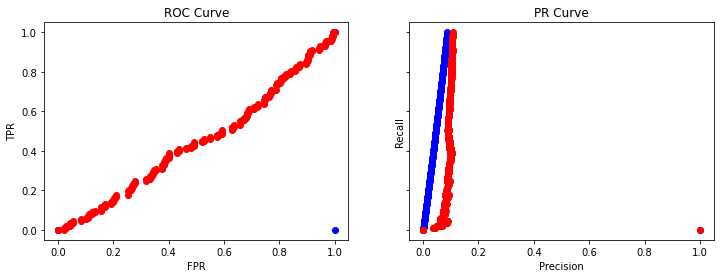

In [ ]:
fit_times = []; eval_times = []; acc_scores = []; rocauc_scores = []

for k in ks:
    print('----- gamma = %f -----' % k)
    clf = svm.SVC(probability=True, class_weight=class_weight, kernel='poly', degree=4, gamma=k)
    fit_time = train_model(clf, X_train, y_train)
    acc_score, rocauc_score, eval_time = evaluate(clf, X_train, y_train, X_valid, y_valid)
    fit_times.append(fit_time); eval_times.append(eval_time)
    acc_scores.append(acc_score); rocauc_scores.append(rocauc_score)

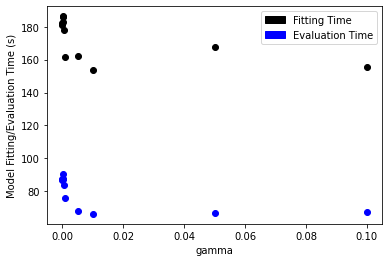

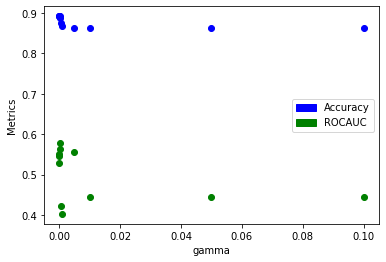

    0_gamma  1_Accuracy  2_ROCAUC  4_fit_time  5_eval_time
0   0.00001    0.891943  0.529555  180.788462    87.487243
1   0.00002    0.891943  0.546897  182.046076    86.943563
2   0.00005    0.891943  0.550551  186.331730    90.250011
3   0.00010    0.891943  0.562708  185.965211    87.689487
4   0.00020    0.888152  0.577692  182.551257    87.632532
5   0.00050    0.875829  0.422477  177.956184    83.795189
6   0.00100    0.867299  0.402815  161.289341    76.162295
7   0.00500    0.862559  0.555484  161.981452    67.740409
8   0.01000    0.862559  0.444488  153.805372    66.261148
9   0.05000    0.862559  0.444507  167.483615    66.668880
10  0.10000    0.862559  0.444507  155.789155    67.402926


         0_gamma  1_Accuracy   2_ROCAUC  4_fit_time  5_eval_time
count  11.000000   11.000000  11.000000   11.000000    11.000000
mean    0.015171    0.877208   0.498335  172.362532    78.912153
std     0.031772    0.013952   0.065833   12.463021    10.091040
min     0.000010    0.862559  

In [ ]:
plot_metrics(ks, 'gamma', True, fit_times, eval_times, acc_scores, rocauc_scores)

Time elapsed (Training): 116.3852 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='sigmoid', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.571225
ROCAUC Score (Training): 0.564430
Accuracy (Validation): 0.559242
ROCAUC Score (Validation): 0.514608
Time elapsed (Evaluation): 57.3858 s


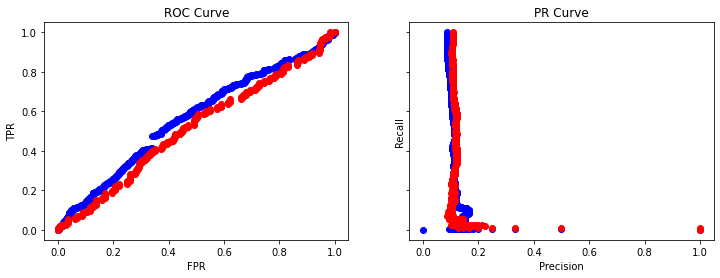

In [ ]:
#signmoid kernal
clf = svm.SVC(probability=True, class_weight=class_weight, kernel='sigmoid') # Set probability=True to enable the predict_proba() API
fit_time = train_model(clf, X_train, y_train)
acc_score, rocauc_score,  eval_time = evaluate(clf, X_train, y_train, X_valid, y_valid)

----- gamma = 0.000010 -----
Time elapsed (Training): 178.2780 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=1e-05,
    kernel='sigmoid', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.683100
ROCAUC Score (Training): 0.661432
Accuracy (Validation): 0.653081
ROCAUC Score (Validation): 0.626421
Time elapsed (Evaluation): 84.2156 s


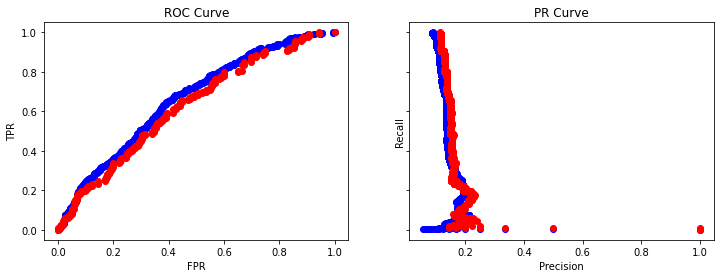

----- gamma = 0.000020 -----
Time elapsed (Training): 173.4006 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=2e-05,
    kernel='sigmoid', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.645177
ROCAUC Score (Training): 0.675515
Accuracy (Validation): 0.629384
ROCAUC Score (Validation): 0.632405
Time elapsed (Evaluation): 80.8282 s


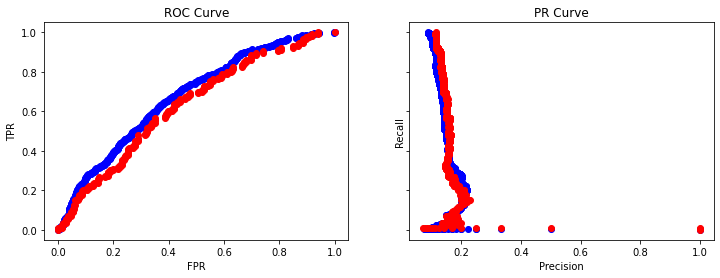

----- gamma = 0.000050 -----
Time elapsed (Training): 168.5421 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=5e-05,
    kernel='sigmoid', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.658213
ROCAUC Score (Training): 0.702010
Accuracy (Validation): 0.627488
ROCAUC Score (Validation): 0.638117
Time elapsed (Evaluation): 78.2561 s


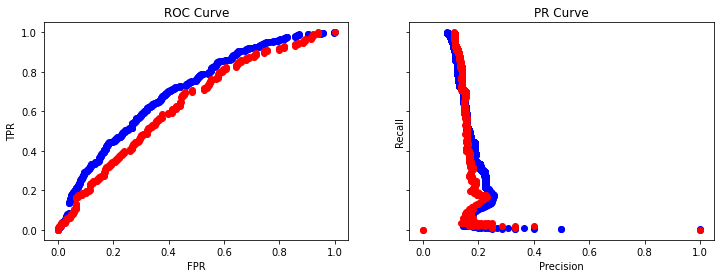

----- gamma = 0.000100 -----
Time elapsed (Training): 166.6946 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.0001,
    kernel='sigmoid', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.661768
ROCAUC Score (Training): 0.725690
Accuracy (Validation): 0.623697
ROCAUC Score (Validation): 0.638089
Time elapsed (Evaluation): 91.0542 s


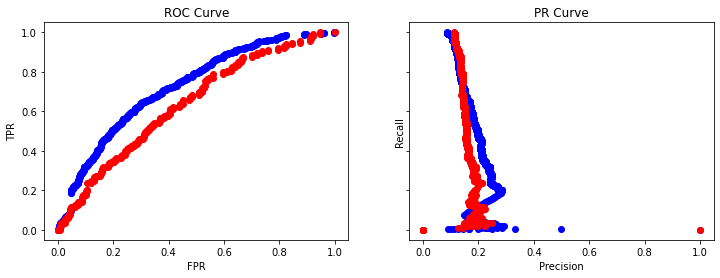

----- gamma = 0.000200 -----
Time elapsed (Training): 162.1797 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.0002,
    kernel='sigmoid', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.675279
ROCAUC Score (Training): 0.747549
Accuracy (Validation): 0.629384
ROCAUC Score (Validation): 0.640945
Time elapsed (Evaluation): 86.6568 s


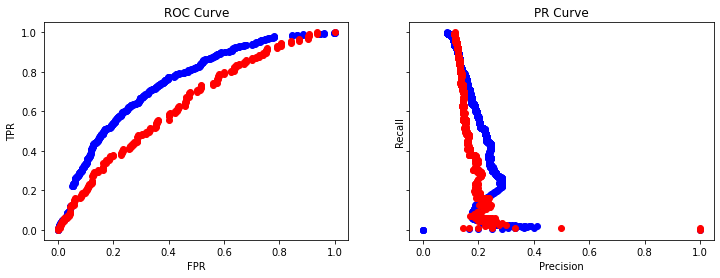

----- gamma = 0.000500 -----
Time elapsed (Training): 145.5117 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.0005,
    kernel='sigmoid', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.664375
ROCAUC Score (Training): 0.717884
Accuracy (Validation): 0.622749
ROCAUC Score (Validation): 0.633702
Time elapsed (Evaluation): 75.8131 s


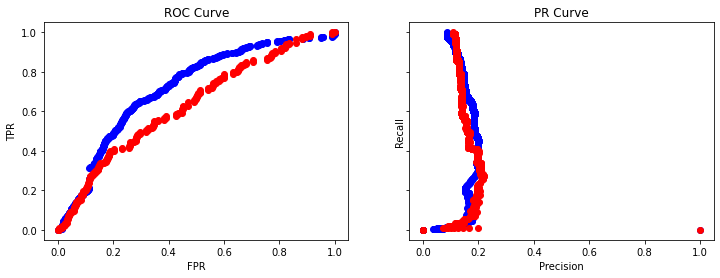

----- gamma = 0.001000 -----
Time elapsed (Training): 114.7042 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.001,
    kernel='sigmoid', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.594217
ROCAUC Score (Training): 0.589469
Accuracy (Validation): 0.555450
ROCAUC Score (Validation): 0.576781
Time elapsed (Evaluation): 56.9169 s


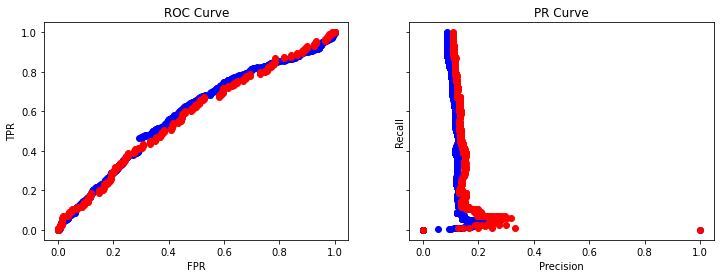

----- gamma = 0.005000 -----
Time elapsed (Training): 99.5213 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.005,
    kernel='sigmoid', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.535909
ROCAUC Score (Training): 0.518518
Accuracy (Validation): 0.539336
ROCAUC Score (Validation): 0.548100
Time elapsed (Evaluation): 48.9964 s


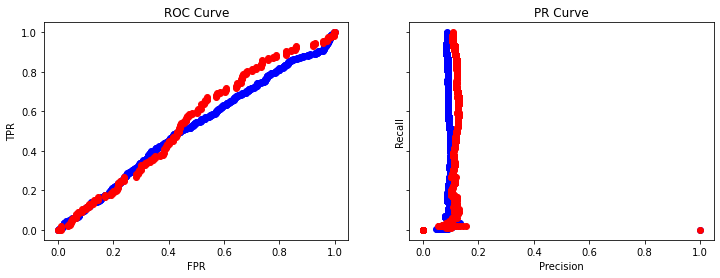

----- gamma = 0.010000 -----
Time elapsed (Training): 112.7143 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.01,
    kernel='sigmoid', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.490875
ROCAUC Score (Training): 0.475855
Accuracy (Validation): 0.490995
ROCAUC Score (Validation): 0.505148
Time elapsed (Evaluation): 53.0300 s


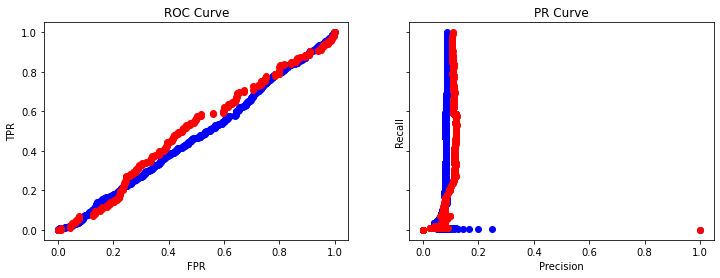

----- gamma = 0.050000 -----
Time elapsed (Training): 108.4021 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.05,
    kernel='sigmoid', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.501304
ROCAUC Score (Training): 0.488514
Accuracy (Validation): 0.501422
ROCAUC Score (Validation): 0.546390
Time elapsed (Evaluation): 51.9460 s


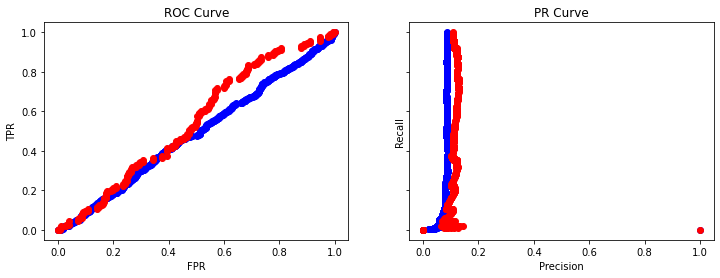

----- gamma = 0.100000 -----
Time elapsed (Training): 100.0362 s
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1.0, 1: 10.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.1,
    kernel='sigmoid', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy (Training): 0.508414
ROCAUC Score (Training): 0.512952
Accuracy (Validation): 0.499526
ROCAUC Score (Validation): 0.459172
Time elapsed (Evaluation): 50.8267 s


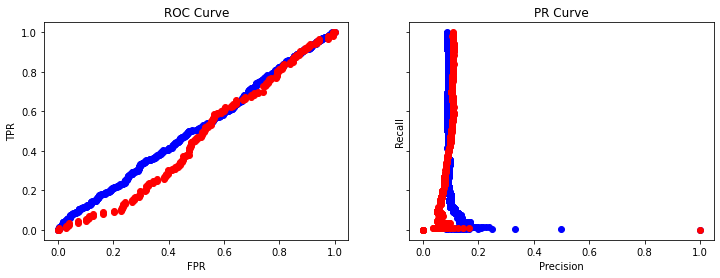

In [ ]:
fit_times = []; eval_times = []; acc_scores = []; rocauc_scores = []

for k in ks:
    print('----- gamma = %f -----' % k)
    clf = svm.SVC(probability=True, class_weight=class_weight, kernel='sigmoid', gamma=k)
    fit_time = train_model(clf, X_train, y_train)
    acc_score, rocauc_score, eval_time = evaluate(clf, X_train, y_train, X_valid, y_valid)
    fit_times.append(fit_time); eval_times.append(eval_time)
    acc_scores.append(acc_score); rocauc_scores.append(rocauc_score)

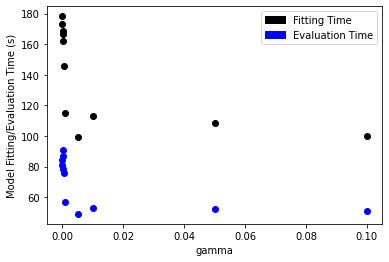

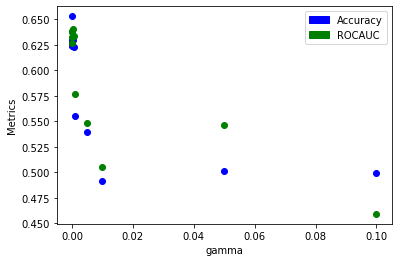

    0_gamma  1_Accuracy  2_ROCAUC  4_fit_time  5_eval_time
0   0.00001    0.653081  0.626421  178.277951    84.215554
1   0.00002    0.629384  0.632405  173.400576    80.828180
2   0.00005    0.627488  0.638117  168.542055    78.256072
3   0.00010    0.623697  0.638089  166.694643    91.054191
4   0.00020    0.629384  0.640945  162.179684    86.656783
5   0.00050    0.622749  0.633702  145.511653    75.813121
6   0.00100    0.555450  0.576781  114.704174    56.916857
7   0.00500    0.539336  0.548100   99.521302    48.996378
8   0.01000    0.490995  0.505148  112.714282    53.029987
9   0.05000    0.501422  0.546390  108.402070    51.946017
10  0.10000    0.499526  0.459172  100.036208    50.826740


         0_gamma  1_Accuracy   2_ROCAUC  4_fit_time  5_eval_time
count  11.000000   11.000000  11.000000   11.000000    11.000000
mean    0.015171    0.579319   0.585933  139.089509    68.958171
std     0.031772    0.062477   0.063422   31.999529    16.504353
min     0.000010    0.490995  

In [ ]:
plot_metrics(ks, 'gamma', True, fit_times, eval_times, acc_scores, rocauc_scores)